In [1]:
import croissant as cro

from astropy.units import s as seconds
import healpy
from lunarsky import Time
import matplotlib.pyplot as plt
import numpy as np

In spherical coordinates, where $\theta$ is the polar angle, the power of a dipole antenna is given by:
$$P(\theta, \nu) \propto (L\nu)^2 \cos^2{\theta} $$

In [2]:
# 1 deg spacing, must be radians
theta = np.linspace(0, np.pi, num=181)
theta.shape = (1, -1, 1)
phi = np.linspace(0, 2 * np.pi, num=360, endpoint=False)
phi.shape = (1, 1, -1)
# 1 MHz resolution frequency
freq = np.linspace(1, 50, num=50)
freq.shape = (-1, 1, 1)
# dipole beam
power = freq**2 * np.cos(theta)**2
power = np.repeat(power, phi.size, axis=-1)

In [3]:
beam = cro.beam.Beam(power, theta=theta, phi=phi, frequencies=freq)

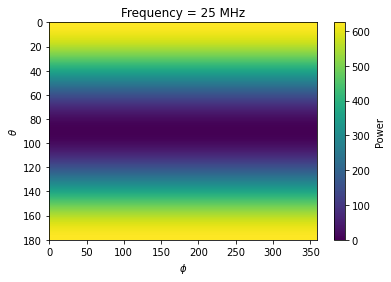

In [4]:
plot_freq = 25  # MHz
freq_ix = np.argmin(np.abs(beam.frequencies-plot_freq))
ex = [beam.phi.min(), beam.phi.max(), beam.theta.max(), beam.theta.min()]
ex_deg = [np.rad2deg(bd) for bd in ex]
plt.figure()
plt.imshow(beam.data[freq_ix], aspect="auto", extent=ex_deg)
plt.colorbar(label="Power")
plt.title(f"Frequency = {beam.frequencies[freq_ix]:.0f} MHz")
plt.xlabel("$\\phi$")
plt.ylabel("$\\theta$")
plt.show()

We use the Global Sky Model (Zheng et al 2016) at 25 MHz as the sky model and extrpolate it by a power law to other frequencies. It has a built-in interface in the sky module of croissant.

In [5]:
spectral_index = -2.5
sky = cro.sky.Sky.gsm(beam.frequencies, power_law=True, gen_freq=25, spectral_index=spectral_index)

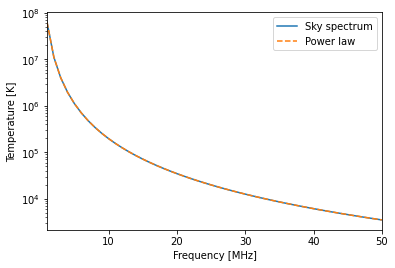

In [6]:
# the sky model is indeed a perfect power law
plt.figure()
plt.plot(sky.frequencies, sky.data[:,0], label="Sky spectrum")
plt.plot(sky.frequencies, sky.frequencies**spectral_index * sky.data[0,0], ls="--", label="Power law")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Temperature [K]")
plt.xlim(sky.frequencies.min(), sky.frequencies.max())
plt.yscale("log")
plt.legend()
plt.show()

In [7]:
# let's do a full sidereal day on the moon
lmax = 32
loc = (-10, 20., 0)
t_start = Time("2022-06-02 15:43:43")
t_end = t_start + cro.constants.sidereal_day_moon * seconds
sim = cro.simulator.Simulator(
    beam, sky, obs_loc=loc, t_start=t_start, N_times=300, t_end=t_end, moon=True, lmax=lmax
)

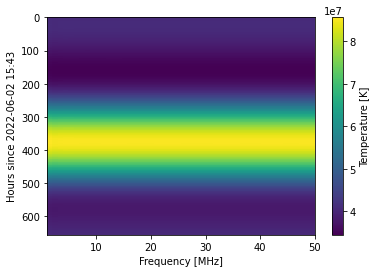

In [8]:
# dpss mode
sim.run(dpss=True, eigenval_cutoff=1e-12, filter_half_width=0.5e-7)
sim.plot(power=-spectral_index)

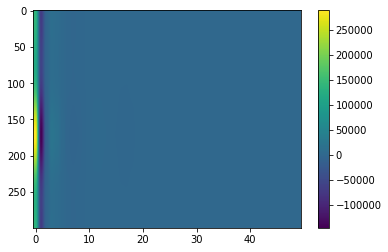

In [9]:
# residuals
sim_freq = cro.simulator.Simulator(
    beam, sky, obs_loc=loc, t_start=t_start, N_times=300, t_end=t_end, moon=True, lmax=lmax
)
sim_freq.run(dpss=False)
plt.figure()
plt.imshow((sim.waterfall - sim_freq.waterfall) * sim.frequencies**2.5, aspect="auto")
plt.colorbar()
plt.show()

In [10]:
print(f"nterms = {sim.beam.coeffs.shape[0]}")

nterms = 13


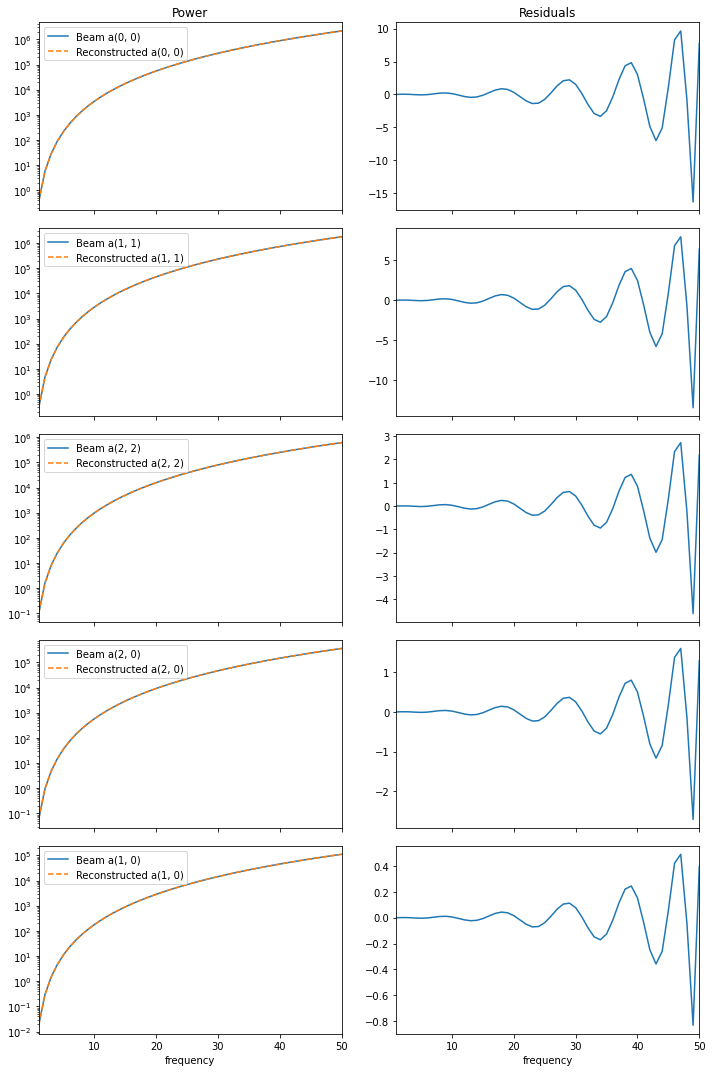

In [11]:
ells, emms = healpy.Alm.getlm(sim.lmax, np.argsort(np.abs(sim.beam.alm[0])**2)[::-1][:5])
beam_alm_recon = sim.design_matrix @ sim.beam.coeffs
fig, axs = plt.subplots(figsize=(10,15), nrows=len(ells), ncols=2, sharex=True, sharey=False)
for i in range(len(ells)):
    ell, emm = ells[i], emms[i]
    ix = healpy.Alm.getidx(sim.lmax, ell, emm)
    plt.sca(axs[i, 0])
    plt.plot(sim.frequencies, np.abs(sim.beam.alm[:, ix])**2, label=f"Beam a{ell,emm}")
    plt.plot(sim.frequencies, np.abs(beam_alm_recon[:, ix])**2, label=f"Reconstructed a{ell,emm}", ls="--")
    plt.legend()
    plt.xlim(sim.frequencies.min(), sim.frequencies.max())
    if i == 0:
        plt.title("Power")
    if i == len(ells) - 1:
        plt.xlabel("frequency")
    plt.sca(axs[i, 1])
    plt.plot(sim.frequencies, np.abs(sim.beam.alm[:, ix])**2 - np.abs(beam_alm_recon[:, ix])**2)
    if i == 0:
        plt.title("Residuals")
    if i == len(ells) - 1:
        plt.xlabel("frequency")
plt.setp(axs[:, 0], yscale="log")
plt.tight_layout()
plt.show()

# DPSS fitting of power laws

In [12]:
from hera_filters.dspec import dpss_operator

In [13]:
freq = np.linspace(1, 50, 50) * 1e6
data = (freq/freq[0]) ** 2

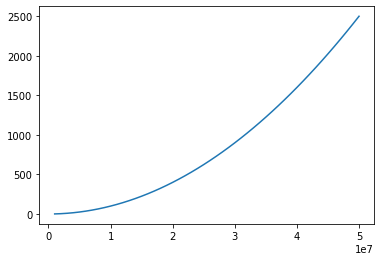

In [14]:
plt.figure()
plt.plot(freq, data)
plt.show()

In [15]:
taus = np.fft.rfftfreq(len(data), 1e6)
delays = np.fft.rfft(data)

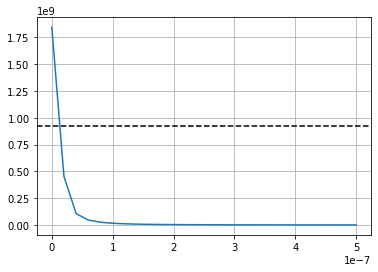

In [16]:
fig, ax = plt.subplots()
ax.plot(taus, np.abs(delays)**2)
ax.axhline(np.max(np.abs(delays)**2) / 2, ls="--", c="k")
ax.grid()
plt.show()

In [17]:
fhw = 0.5e-7
A = dpss_operator(
    freq, [0], [fhw], eigenval_cutoff=[1e-12], edge_suppression=None, nterms=None, avg_suppression=None,
)[0].real

print(A.shape[-1])

13


In [18]:
np.allclose(A, sim.design_matrix)

True

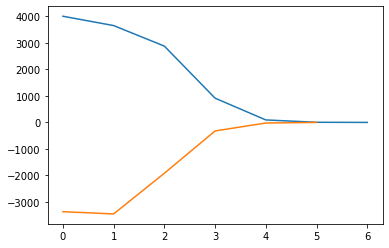

In [19]:
_data = np.linalg.inv(A.T @ A) @ A.T @ data
plt.figure()
plt.plot(_data[::2])
plt.plot(_data[1::2])
plt.show()

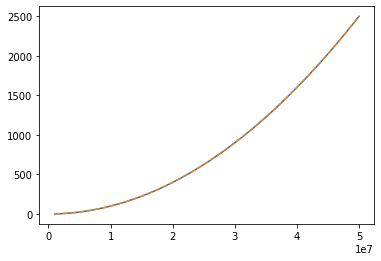

In [20]:
plt.figure()
plt.plot(freq, data)
plt.plot(freq, A @ _data, ls="--")
plt.show()

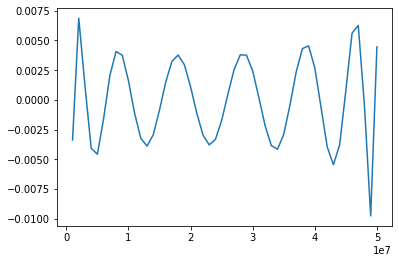

In [21]:
plt.figure()
plt.plot(freq, data - A @ _data)
plt.show()